# Magnitude structure for minimizing negative transfer of knowledge in MOGP


Given a number of outputs $M=3$, each one with $Q_{\text{unique}}=3$ latent components, with $Q_{\text{pair}}=1$  pairwise components and $Q_{\text{shared}}=2$ shared components.

This leads to a total of 

\begin{align}
Q_{\text{total}} & = M * Q_u + \binom{M}{2} Q_p + Q_s \\
Q_{\text{total}} & = 3 * 3 + 3 * 1 * + 2 = 14
\end{align}

With this, a binary matrix with the weights has the form:

In [1]:
import sys
sys.path.insert(0, '../')

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_probability as tfp

import mogptk
from mogptk.restricted_mosm import _create_mask

import matplotlib as mpl

# TODO: remove when done:
%reload_ext autoreload
%autoreload 2

# Use mask on MOSM

In [2]:
n_points = 100
t = np.linspace(0, 6, n_points)

y1 = np.sin(6 * t)
y1 += np.random.normal(scale=0.3, size=len(t))

y2 = np.sin(6 * t + 2)
y2 += np.random.normal(scale=0.3, size=len(t))

y3 = 0.7 * np.sin(6 * t) - 0.7 * np.sin(4 * t)
y3 += np.random.normal(scale=0.3, size=len(t))

y4 = np.sin(6 * (t - 0.5))
y4 += np.random.normal(scale=0.3, size=len(t))

data1 = mogptk.Data(t, y1, name='A')
data2 = mogptk.Data(t, y2, name='B')
data3 = mogptk.Data(t, y3, name='C')
data4 = mogptk.Data(t, y4, name='D')

# create dataset
dataset = mogptk.DataSet(data1, data2, data3, data4)

for data in dataset:
    data.remove_randomly(pct=0.5)

In [ ]:
dataset.plot();

In [3]:
M = len(dataset)
# Q_u = np.zeros(M).astype(int)
Q_u = np.ones(M).astype(int)
Q_p = 1
Q_s = 1

prior = tfp.distributions.Laplace(loc=np.zeros(M), scale=np.ones(M) * 20)
model = mogptk.RMOSM(dataset, Q_u=Q_u, Q_p=Q_p, Q_s=Q_s, magnitude_prior=None)
W, _, mode = _create_mask(M, Q_u, Q_p, Q_s)

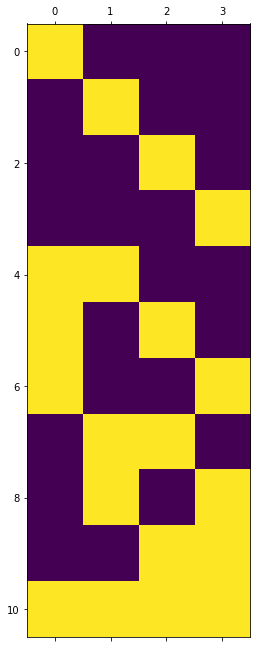

In [4]:
plt.matshow(W)

In [5]:
model.init_parameters()

In [6]:
x_pred, _ = model.dataset.get_data()

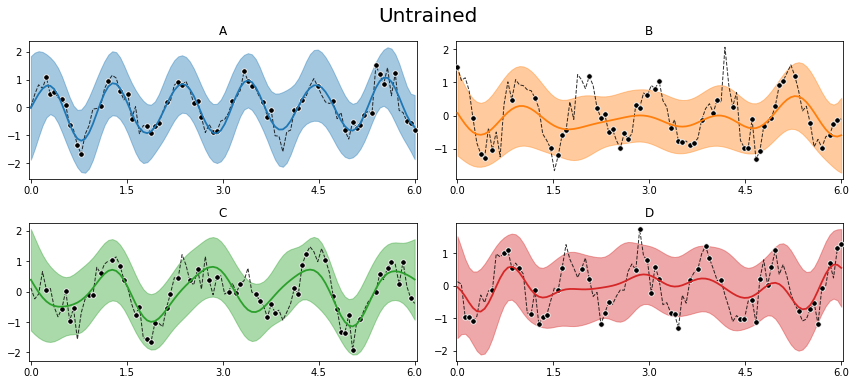

In [7]:
model.predict(x_pred)
model.plot_prediction(title='Untrained');

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdc444b4cd0>)

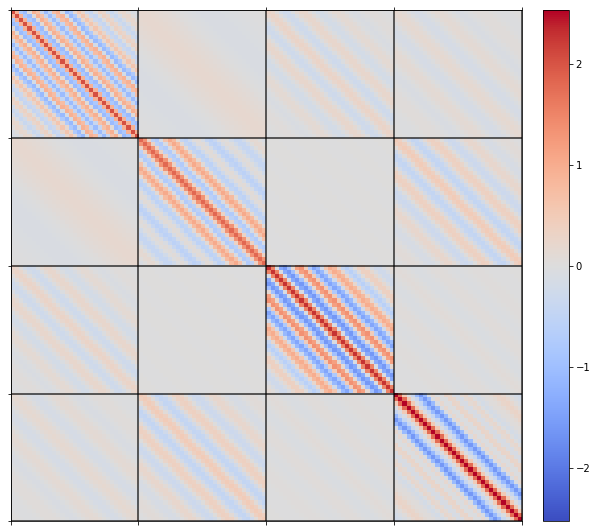

In [8]:
model.plot_gram_matrix()

In [9]:
model.train(tol=1e-50, maxiter=500, verbose=True)

Starting optimization
 >Model: R-MOSM
 >Channels: 4                    
 >Components: 11
 >Training points: 200
 >Parameters: 97
 >Initial NLL: 262.042
Optimization finished in 1.43 minutes
 >Final NLL: 62.524 



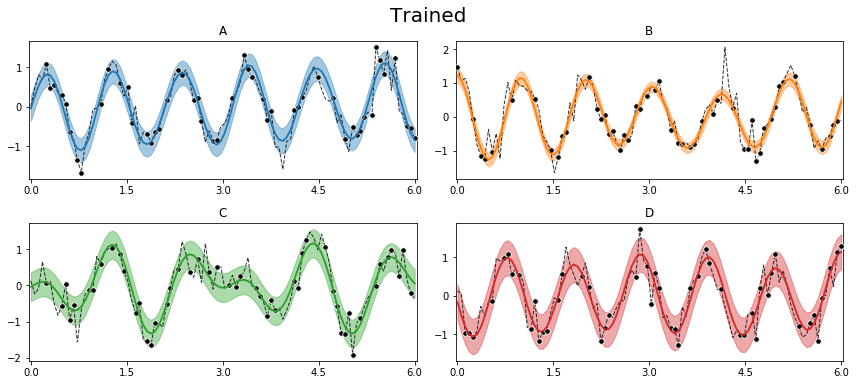

In [10]:
model.predict(x_pred);

model.plot_prediction(title='Trained');

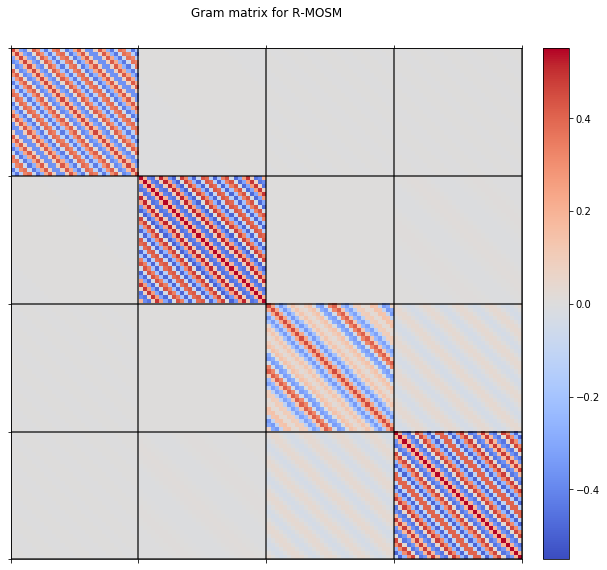

In [11]:
model.plot_gram_matrix(title='Gram matrix for R-MOSM');

## Test with GONU

In [12]:
oil = mogptk.LoadCSV('data/gonu/brent-daily.csv',
                     'Date',
                     'Price',
                     name='Oil',)
                     
gold = mogptk.LoadCSV('data/gonu/lmba-gold-usd-am-daily.csv',
                      'Date',
                      'Price',
                      name='Gold',
                      na_values='.')
nasdaq = mogptk.LoadCSV('data/gonu/nasdaq.csv',
                        'Date',
                        'Adj Close',
                        name='NASDAQ',)
usd = mogptk.LoadCSV('data/gonu/TWEXB.csv',
                     'Date',
                     'Price',
                     name='USD',)

cols = ['Gold', 'Oil', 'NASDAQ', 'USD']
dataset2 = mogptk.DataSet(gold, oil, nasdaq, usd)

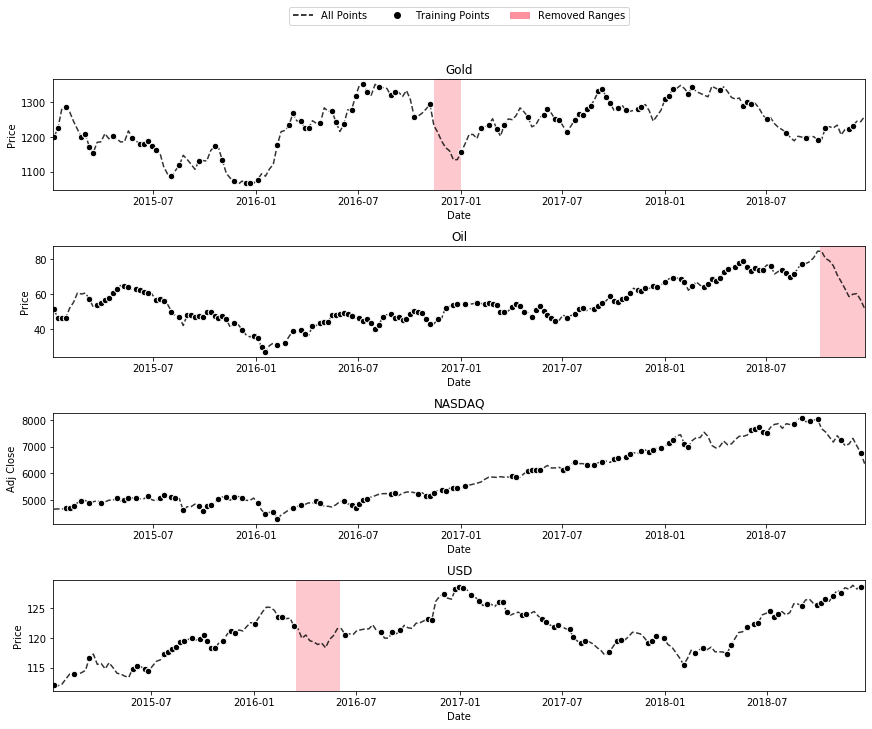

In [13]:
np.random.seed(1)
for i, channel in enumerate(dataset2):
    channel.filter('2015-01-01', '2018-12-31')
    channel.aggregate('7D')
    
    channel.transform(mogptk.TransformDetrend)
    channel.transform(mogptk.TransformLog)
    # channel.transform(mogptk.TransformNormalize)
    
    if i == 0:
        channel.remove_range('2016-11-15', '2017-01-01')
        channel.remove_randomly(pct=0.6)
    if i == 1:
        channel.remove_range('2018-10-05', None)
        channel.remove_randomly(pct=0.3)
    if i == 2:
        channel.remove_randomly(pct=0.6)
    if i == 3:
        channel.remove_range('2016-03-15', '2016-06-01')
        channel.remove_randomly(pct=0.6)

dataset2.plot();

In [14]:
M = len(dataset2)
Q_u = np.zeros(M).astype(int)
Q_p = 1
Q_s = 1

# prior = tfp.distributions.Laplace(loc=np.zeros(M), scale=np.ones(M) * 20)
prior = None
rmosm = mogptk.RMOSM(dataset2, Q_u=Q_u, Q_p=Q_p, Q_s=Q_s, magnitude_prior=prior)

mosm = mogptk.MOSM(dataset2, Q=3)

In [15]:
for i in range(len(dataset2)):
    dataset2[i].set_prediction_range('2015-01-01', '2018-12-31', step='1D')

#### MOSM on gonu

In [16]:
mosm.init_parameters()

mosm.train(tol=1e-50, maxiter=5000, verbose=True)

Starting optimization
 >Model: MOSM
 >Channels: 4                    
 >Components: 3
 >Training points: 382
 >Parameters: 65
 >Initial NLL: 409.154
Optimization finished in 11.27 minutes
 >Final NLL: -147.195 



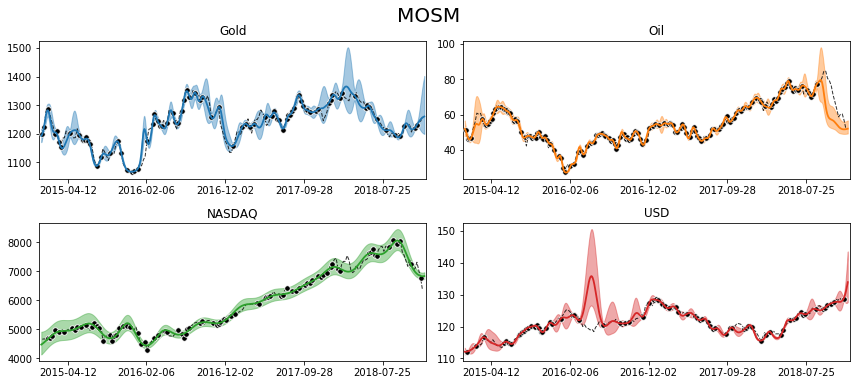

In [17]:
mosm.predict()
mosm.plot_prediction(title='MOSM');

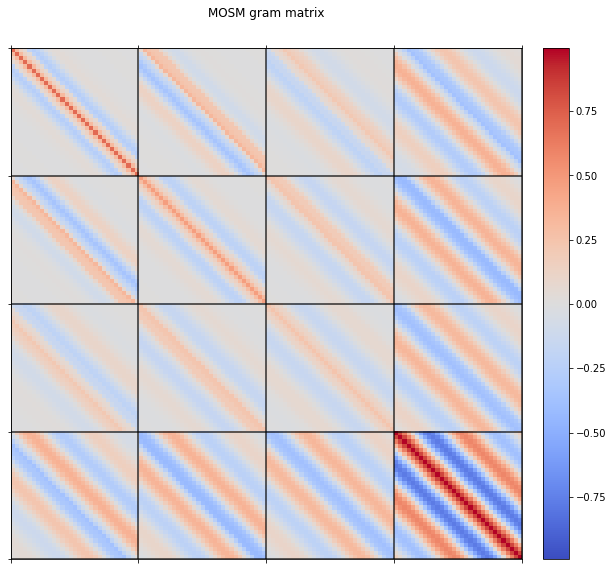

In [26]:
mosm.plot_gram_matrix(title='MOSM gram matrix');

#### R-MOSM on GONU

In [19]:
rmosm.init_parameters()

rmosm.train(tol=1e-50, maxiter=5000, verbose=True)

Starting optimization
 >Model: R-MOSM
 >Channels: 4                    
 >Components: 7
 >Training points: 382
 >Parameters: 85
 >Initial NLL: 408.615
Optimization finished in 9.50 minutes
 >Final NLL: -133.718 



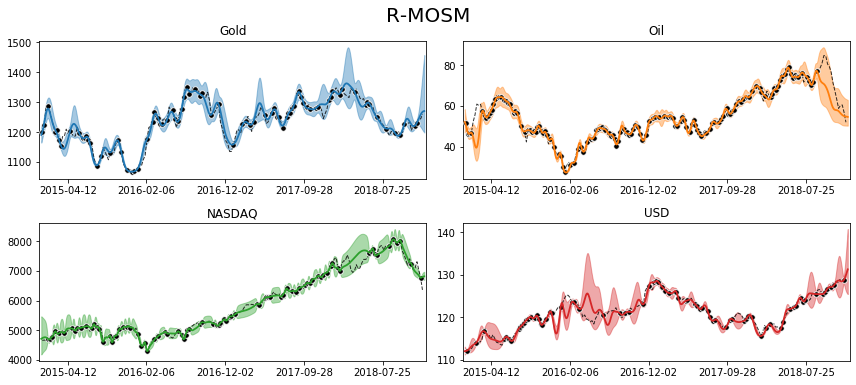

In [20]:
rmosm.predict()
rmosm.plot_prediction(title='R-MOSM');

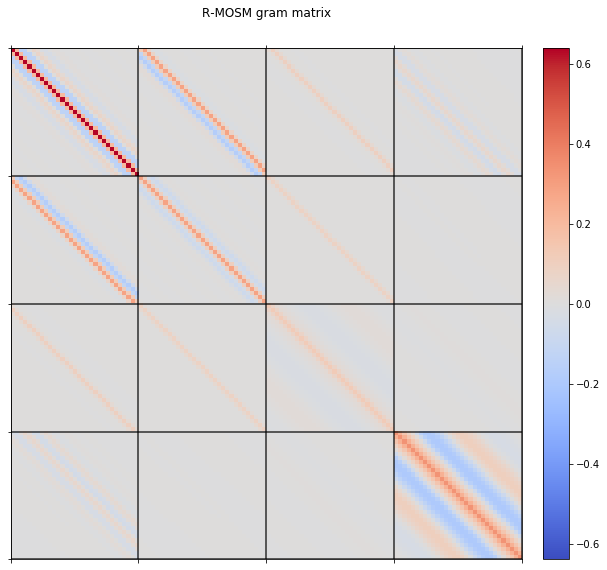

In [27]:
rmosm.plot_gram_matrix(title='R-MOSM gram matrix');